# Model Development

In [1]:
import sys
sys.path.append('..')

import torch
import torch.optim as optim
import config
import numpy as np
from utils import *
from data import Data
from net import LeNet5
from train import Train
from test import Test
from config import config

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


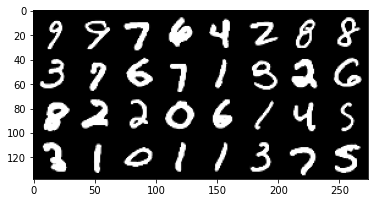

In [2]:
DEVICE = torch.device(config.device)
_data = Data(train_batch_size=config.train_batch_size, test_batch_size=config.test_batch_size)
_data.visualize()
TRAIN_LOADER, TEST_LOADER = _data.get_loaders()
MODEL = LeNet5().to(DEVICE)
OPTIMIZER = optim.SGD(MODEL.parameters(), lr=config.lr, momentum=config.momentum)
CRITERION = torch.nn.NLLLoss()
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', patience=config.patience)

In [3]:
# run this only if you want to trin the model.
# model.pth already exists in the project root.
train_loss = Train(
    model=MODEL,
    train_loader=TRAIN_LOADER,
    optimizer=OPTIMIZER,
    criterion=CRITERION,
    scheduler=SCHEDULER,
    epochs=config.epochs,
    device=DEVICE,
    save_path=config.save_path,
    verbose=config.verbose,
    verbose_step=config.verbose_step
).train()


DEVICE - cpu || EPOCHS - 10 || LEARNING RATE - 0.001.


EPOCH - 1/10 || START AT - 05:08:40 18|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 2.10034 | Time: 25.22s.

	Train Step - 1000/1875 | Train Step Loss: 0.55117 | Time: 24.98s.

	Train Step - 1500/1875 | Train Step Loss: 0.37611 | Time: 25.81s.

	EPOCH - 1/10 || TRAIN LOSS - 0.87044 || TIME ELAPSED - 94.02s.


EPOCH - 2/10 || START AT - 05:10:14 18|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 0.25922 | Time: 23.81s.

	Train Step - 1000/1875 | Train Step Loss: 0.22336 | Time: 23.17s.

	Train Step - 1500/1875 | Train Step Loss: 0.20420 | Time: 24.02s.

	EPOCH - 2/10 || TRAIN LOSS - 0.21851 || TIME ELAPSED - 87.85s.


EPOCH - 3/10 || START AT - 05:11:42 18|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 0.16112 | Time: 22.82s.

	Train Step - 1000/1875 | Train Step Loss: 0.14944 | Time: 22.75s.

	Train Step - 1500/1875 | Train Step Loss: 0.14511 

In [3]:
image_set, label_set, pred_set, model = Test(
    model=MODEL,
    test_loader=TEST_LOADER,
    device=DEVICE,
    save_path=config.save_path,
    test_run=config.test_run
).test()

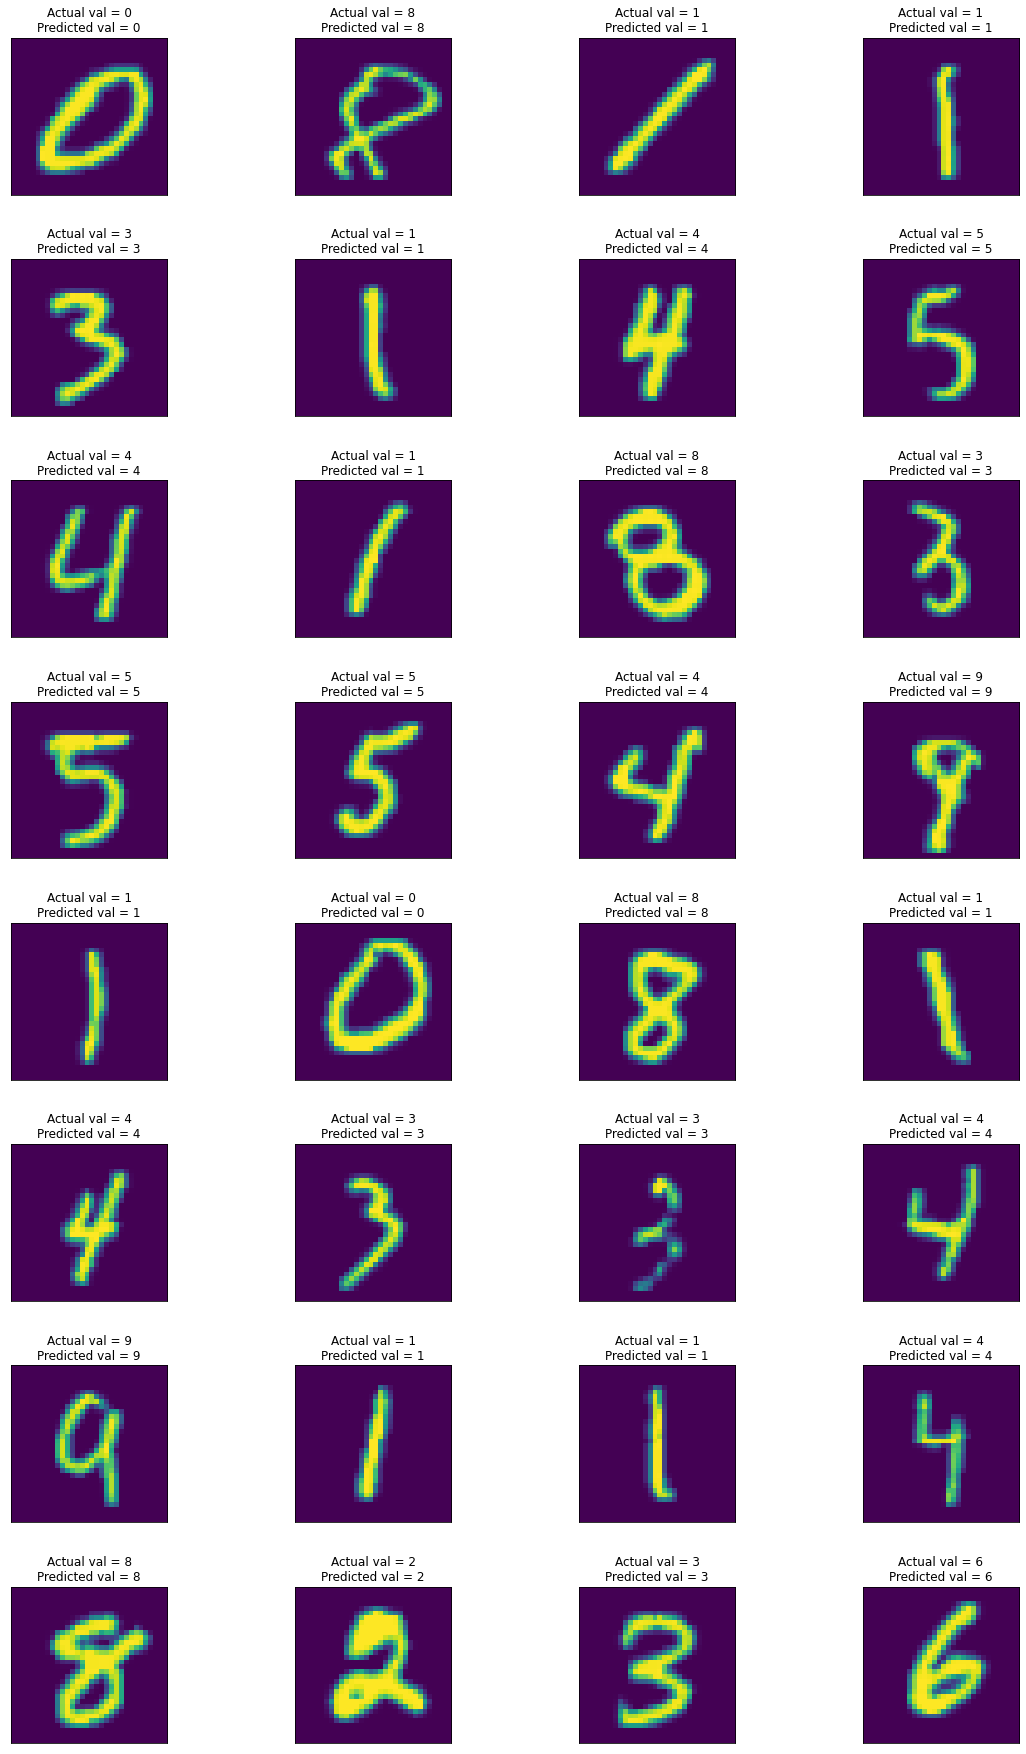

In [4]:
plot_output(image_set, label_set, pred_set)

# Model Deployment
* [Reference 1](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-and-where?tabs=python)
* [Reference 2](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service?tabs=python)
* [Reference 3](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-kubernetes?tabs=python)
* [Reference 4](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.environment.environment?view=azure-ml-py)
* [Video reference 1](https://www.youtube.com/watch?v=2OgBxYCnVGk)

In [2]:
# importing libraries
import json
import requests
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import LocalWebservice

# # kubernetes
# from azureml.core.compute import AksCompute, ComputeTarget
# from azureml.core.webservice import AksWebservice

In [3]:
# connecting to the workspace
'''
ws = Workspace(subscription_id="<subscription_id>",
               resource_group="<resource_group>",
               workspace_name="<workspace_name>")
'''
workspace = Workspace.from_config()
print(f'''Workspace name: {workspace.name}\nWorkspace region: {workspace.location}\nWorkspace subscription ID: {workspace.subscription_id}\nWorkspace resource group: {workspace.resource_group}''')

Workspace name: ml_workspace_version_1
Workspace region: centralindia
Workspace subscription ID: 2006ce9b-738e-4ab3-82ce-eb92cd6cbee2
Workspace resource group: ml_version_1


In [4]:
# registering a model
registered_model = Model.register(workspace=workspace,
                                  model_name="digit_recognizer",
                                  model_path=f"./model.pth",
                                  description="A demo model to recognize digits.")

Registering model digit_recognizer


In [6]:
# defining an environment and inference configuration.
env = Environment.from_pip_requirements(name="digit_recognizer_environment", file_path="./requirements.txt")
inference_config = InferenceConfig(environment=env,
                                   source_directory="./source_dir",
                                   entry_script="./entry_point.py")

In [7]:
# defining deployment configuration
# AKS (arc kubernetes services) implementation
# ?? comment the below lines except the last one and uncomment the last line to make it local webservice deployment
# ## attaching the current workspace to an existing kubernetes clusture
# attach_config = AksCompute.attach_configuration(resource_group = "ML_V1",
#                                                 cluster_name = "mlaksv1")
# aks_target = ComputeTarget.attach(workspace=workspace, name='mlaksv1', attach_configuration=attach_config)
# ## Wait for the attach process to complete
# aks_target.wait_for_completion(show_output=True)

## getting deployment configurations
# aks_target = AksCompute(workspace=workspace, name="mlaksv1")
# deployment_config = AksWebservice.deploy_configuration(cpu_cores=2, memory_gb=4)
deployment_config = LocalWebservice.deploy_configuration(port=6789)

In [8]:
# deploying ML model
deploy = Model(workspace=workspace, id=registered_model.id)
service = Model.deploy(workspace=workspace,
                        name="digit-recognizer-service-v1",
                        models=[registered_model],
                        inference_config=inference_config,
                        deployment_config=deployment_config,
                        overwrite=True)
service.wait_for_deployment(show_output=True)
print(service.get_logs())

Generating Docker build context.
2021/05/18 13:22:04 Downloading source code...
2021/05/18 13:22:05 Finished downloading source code
2021/05/18 13:22:05 Creating Docker network: acb_default_network, driver: 'bridge'
2021/05/18 13:22:06 Successfully set up Docker network: acb_default_network
2021/05/18 13:22:06 Setting up Docker configuration...
2021/05/18 13:22:06 Successfully set up Docker configuration
2021/05/18 13:22:06 Logging in to registry: mlworkspaceversion1.azurecr.io
2021/05/18 13:22:07 Successfully logged into mlworkspaceversion1.azurecr.io
2021/05/18 13:22:07 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/05/18 13:22:07 Scanning for dependencies...
2021/05/18 13:22:08 Successfully scanned dependencies
2021/05/18 13:22:08 Launching container with name: acb_step_0
Sending build context to Docker daemon  66.56kB
Step 1/18 : FROM mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210301.v1@sha256:000d6c43f606ce

In [14]:
# test deployed model
uri = service.scoring_uri
response = requests.get("http://localhost:6789")
print("Localhost response -> ", response)
headers = {
    "Content-Type": "application/json"
    }
data = {
    "query": "What color is the fox",
    "context": "The quick brown fox jumped over the lazy dog."
    }
data = json.dumps(data)
response = requests.post(uri, data=data, headers=headers)
print(f"URI -> {uri}")
print("URI response -> ", response.json())

Localhost response ->  <Response [200]>
URI -> http://localhost:6789/score
URI response ->  test is {'query': 'What color is the fox', 'context': 'The quick brown fox jumped over the lazy dog.'}
